`--- Day 6: Chronal Coordinates ---`

In [1]:
from matplotlib import pyplot as plt

In [2]:
coords = list(map(lambda x: list(map(int, x.split(', '))), open('input.txt').read().splitlines()))

In [3]:
def manhattan(a, b):
    return sum(map(abs, (a_i - b_i for a_i, b_i in zip(a, b))))

In [4]:
# check the 'size' of the problem...
minx = min(p[0] for p in coords)
miny = min(p[1] for p in coords)

maxx = max(p[0] for p in coords)
maxy = max(p[1] for p in coords)

maxdist = manhattan((minx, miny), (maxx, maxy))

print(f'There are {len(coords)} points, bounded within {minx, miny} and {maxx, maxy}.\n'
      f'The Manhattan dist between corners is {maxdist}\n'
      f'There are {(maxx - minx) * (maxy - miny)} coords in the bounding rectangle.')


There are 50 points, bounded within (67, 41) and (357, 353).
The Manhattan dist between corners is 602
There are 90480 coords in the bounding rectangle.


# Problem description
Your goal is to find the size of the largest area that isn't infinite. For example, consider the following list of coordinates:
```
1, 1
1, 6
8, 3
3, 4
5, 5
8, 9
```
If we name these coordinates A through F, we can draw them on a grid, putting 0,0 at the top left:
```
..........
.A........
..........
........C.
...D......
.....E....
.B........
..........
..........
........F.
```
This view is partial - the actual grid extends infinitely in all directions. Using the Manhattan distance, each location's closest coordinate can be determined, shown here in lowercase:
```
aaaaa.cccc
aAaaa.cccc
aaaddecccc
aadddeccCc
..dDdeeccc
bb.deEeecc
bBb.eeee..
bbb.eeefff
bbb.eeffff
bbb.ffffFf
```
Locations shown as . are equally far from two or more coordinates, and so they don't count as being closest to any.

In this example, the areas of coordinates A, B, C, and F are infinite - while not shown here, their areas extend forever outside the visible grid. However, the areas of coordinates D and E are finite: D is closest to 9 locations, and E is closest to 17 (both including the coordinate's location itself). Therefore, in this example, the size of the largest area is 17.

**What is the size of the largest area that isn't infinite?**

# Solution
**Hypothesis**: The nearest neighbours of the points on the boundary have infinite areas.

**Proof**: Err...


In [5]:
def nearest_neighbours(p, points):
    dists = list(map(lambda x: manhattan(p, x), points))
    mindist = min(dists)
    return [i for i, _ in enumerate(dists) if dists[i] == mindist]
 
def mkgrid(points):
    minx = min(p[0] for p in points)
    miny = min(p[1] for p in points)

    maxx = max(p[0] for p in points)
    maxy = max(p[1] for p in points)

    grid = []
    # naive solution, assuming the hypothesis...
    for y in range(miny, maxy + 1):
        row = []
        for x in range(minx, maxx + 1):
            row.append(nearest_neighbours((x, y), points))
        grid.append(row)
    return grid

def dump(grid, points): # for visual comparison against the example...
    minx = min(p[0] for p in points)
    miny = min(p[1] for p in points)

    transformed_points = [(x - minx, y - miny) for x, y in points]
    for y, row in enumerate(grid):
        print()
        for x, col in enumerate(row):
            labels = 'ABCDEF' if (x, y) in transformed_points else 'abcdef'
            print(labels[col[0]] if len(col) == 1 else '.', end='')
    print()

In [6]:
test_coords = [(1, 1),
               (1, 6),
               (8, 3),
               (3, 4),
               (5, 5),
               (8, 9)]

In [7]:
test = mkgrid(test_coords)
dump(test, test_coords)


Aaaa.ccc
aaddeccc
adddeccC
.dDdeecc
b.deEeec
Bb.eeee.
bb.eeeff
bb.eefff
bb.ffffF


In [8]:
import pandas as pd
import numpy as np

In [9]:
def max_finite(grid):
    df = pd.DataFrame(grid, index=range(len(grid)), columns=range(len(grid[0])))

    transformed = grid_transform(df)

    areas = transformed.apply(pd.value_counts).sum(axis=1).astype(np.int)
    areas.index = areas.index.astype(np.int)

    mask = pd.DataFrame(np.zeros_like(transformed, dtype=np.bool))
    mask.iloc[[0, -1], :] = True
    mask.iloc[:, [0, -1]] = True

    boundary_values = pd.Series(transformed[mask].values.flatten()).dropna().drop_duplicates().astype(np.int)

    return areas.loc[lambda x: [i for i in x.index if i not in boundary_values.values]].max()

def grid_transform(griddf):
    return griddf.applymap(lambda x: x[0] if len(x) == 1 else np.nan)

max_finite(test)

17

# Part 1

In [10]:
grid = mkgrid(coords)

In [11]:
max_finite(grid)

3569

# Part 2

In [12]:
def mkgrid2(points):
    minx = min(p[0] for p in points)
    miny = min(p[1] for p in points)

    maxx = max(p[0] for p in points)
    maxy = max(p[1] for p in points)

    grid = []

    for y in range(miny, maxy + 1):
        row = []
        for x in range(minx, maxx + 1):
            row.append(summed_distance((x, y), points))
        grid.append(row)
    return grid

def summed_distance(p, points):
    return sum(manhattan(p,x) for x in points)

In [13]:
def count_within(points, lim):
    return pd.DataFrame(mkgrid2(points)).where(lambda x: x < lim).count().sum()

count_within(test_coords, 32)

16

In [14]:
count_within(coords, 10000)

48978

# Visuals

In [15]:
g = pd.DataFrame(mkgrid2(coords))

In [16]:
from mpl_toolkits.mplot3d import Axes3D

C:\Users\MarkOakden\Anaconda3\envs\dspython36\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


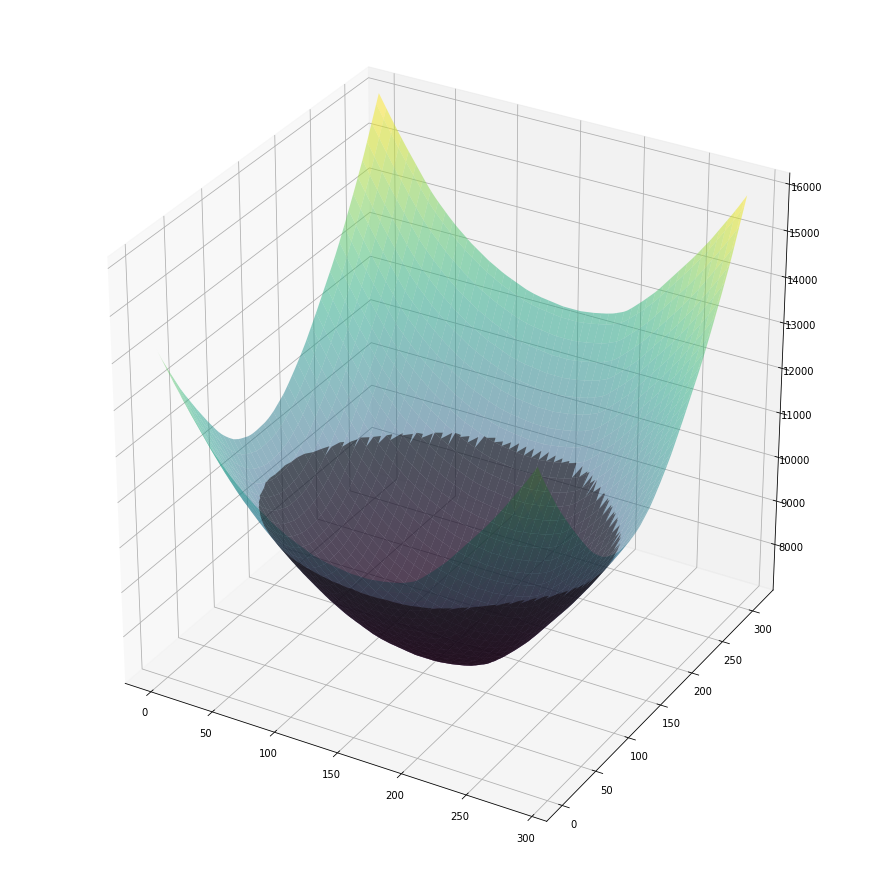

In [17]:
fig = plt.figure(figsize=(12,12))
ax = Axes3D(fig)
Y, X = np.meshgrid(g.index.values, g.columns.values)
ax.plot_surface(X, Y, g.T, cmap='viridis', alpha=0.5)
ax.plot_surface(X, Y, g.where(lambda x: x < 10000).T, cmap='hot', alpha=0.5)
plt.show()

In [22]:
import seaborn as sns

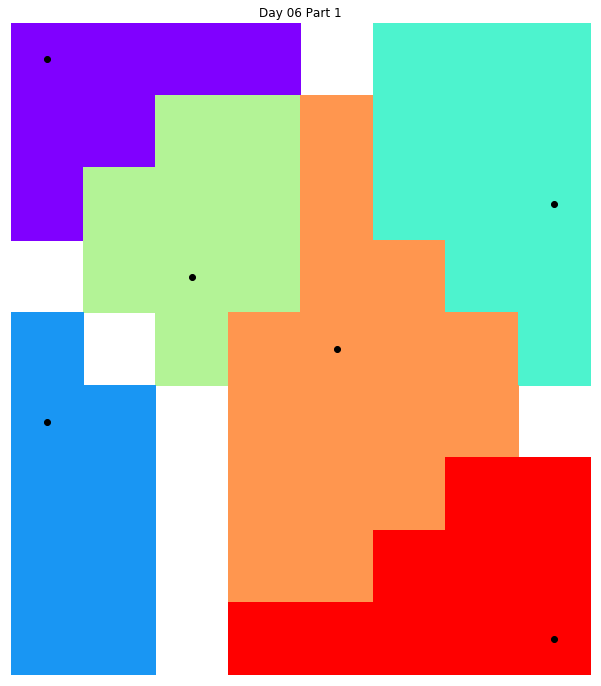

In [50]:
def part1_plot(coords, cmap='rainbow', pointcolour='black'):
    grid = grid_transform(pd.DataFrame(mkgrid(coords)))

    fig, ax = plt.subplots(figsize=(12, 12))
    sns.heatmap(grid, cmap=cmap, cbar=False, square=True, xticklabels=[], yticklabels=[], ax=ax)
    
    x_, y_ = list(zip(*coords))
    x = [xi - min(x_) + 0.5 for xi in x_]
    y = [yi - min(y_) + 0.5 for yi in y_]
    ax.scatter(x, y, color=pointcolour)
    ax.set_title('Day 06 Part 1')
    
part1_plot(test_coords)

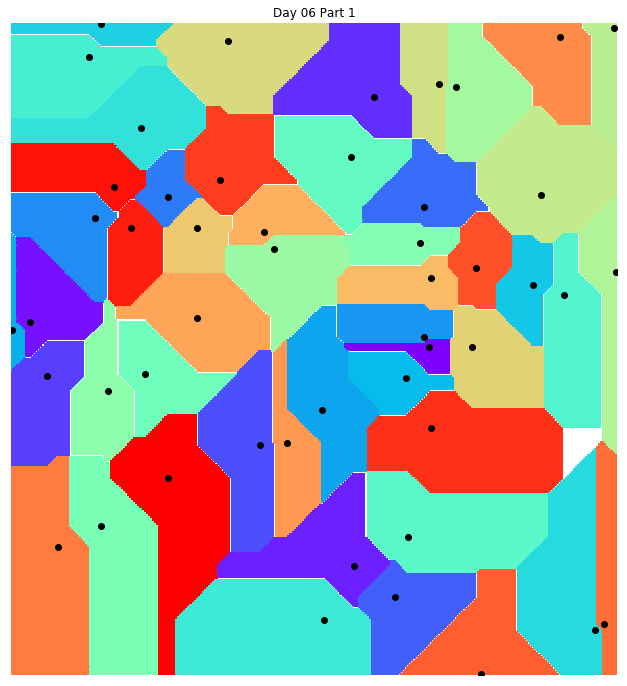

In [51]:
part1_plot(coords)
plt.savefig('part1.png')